In [2]:
# Data
import yfinance as yf
import pandas_datareader as web
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler

# Algorithms
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# Model evaluation
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error

# Time series
from pmdarima import auto_arima
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf

# Load data

In [14]:
# Load data

# Amazon vs Microsoft, Google, IBM 
# Daily return past 10 years 
data = yf.download(tickers="AMZN MSFT GOOGL IBM", period='10y', interval='1d')

[*********************100%***********************]  4 of 4 completed


In [15]:
# Save stock data - Close price (adjusted) 

stk_data = data[['Adj Close']]
stk_data.columns = stk_data.columns.droplevel()

In [19]:
stk_data.index

DatetimeIndex(['2011-08-09', '2011-08-10', '2011-08-11', '2011-08-12',
               '2011-08-15', '2011-08-16', '2011-08-17', '2011-08-18',
               '2011-08-19', '2011-08-22',
               ...
               '2021-07-27', '2021-07-28', '2021-07-29', '2021-07-30',
               '2021-08-02', '2021-08-03', '2021-08-04', '2021-08-05',
               '2021-08-06', '2021-08-09'],
              dtype='datetime64[ns]', name='Date', length=2517, freq=None)

In [20]:
# FX and market indices
# Trading dates may vary - will be adjusted

ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

ccy_data = web.DataReader(ccy_tickers, 'fred', start='2011-08-09', end='2021-08-09')
idx_data = web.DataReader(idx_tickers, 'fred', start='2011-08-09', end='2021-08-09')

For modeling, response (Y) and predictor (X) variables will be determined. Amazon stock pricing is the objective of this project. 

The data are represented with daily stock prices, but the response variable (Y) will be the weekly return of Amazon. The number of trading days a week will be assumed to be 5 days.

Independent variables (X) will include stock prices of correlated (likely) companies, market (foreign currency and indices) and lagged stock prices of Amazon. Returns will be rescaled using natural log. Logarithmic price scales tend to show less severe price increases or decreases than linear price scales - so it prevents small price changes being seen more trival than larger counterparts [reference](https://www.investopedia.com/terms/l/logarithmicscale.asp).


The major limitation of this pricing prediction model is that it only concerns correlated stocks and technical indicators, and leaving further investigations with other possible features used in fundamental analysis (i.e. performance reports, news). 



In [44]:
# Construct Y variable - AMZN stock price (5-day)

# To find correlations with other stocks, we need to get 5 day lagged price
# .diff() function produces 5-day returns after natural log rescaling
# .shift() function returns the stock prices that are 5 days later

periods = 5
Y = np.log(stk_data.loc[:, 'AMZN']).diff(periods).shift(-periods)
Y.name = Y.name + '_pred'

In [45]:
stk_data

,AMZN,GOOGL,IBM,MSFT
Date,,,,
2011-08-09,205.089996,286.992004,121.667671,20.497541
2011-08-10,194.130005,274.779785,115.912712,19.391731
2011-08-11,198.360001,281.346344,118.900749,20.185030
2011-08-12,202.300003,282.167175,119.949028,20.112915
2011-08-15,202.949997,278.893890,123.364937,20.441450
...,...,...,...,...
2021-08-03,3366.239990,2712.600098,144.070007,287.119995
2021-08-04,3354.719971,2702.510010,142.759995,286.510010
2021-08-05,3375.989990,2725.030029,142.770004,289.519989


In [69]:
# Construct X variables 

# 5-day returns for Correlated stocks - 'GOOGL', 'IBM', 'MSFT'
X1 = np.log(stk_data.loc[:, ('GOOGL', 'IBM', 'MSFT')]).diff(periods)

# 5-day returns for Foreign currency & Market indices
X2 = np.log(ccy_data).diff(periods)
X3 = np.log(idx_data).diff(periods)

# Lagged 5-day, 15-day, 30-day, 60-day AMZN returns 
X4 = [np.log(stk_data.loc[:, 'AMZN']).diff(i) for i in [periods, periods*3, periods*6,  periods*12]]
X4 = pd.concat(X4, axis=1)
X4.columns = ['AMZN_DT', 'AMZN_3DT', 'AMZN_6DT', 'AMZN_12DT']

In [81]:
# Combine all X variables

X = pd.concat([X1, X2, X3, X4], axis=1)

In [84]:
# Reconstruct dataset with X, Y variables
# Remove row records that contain at least one null values 
# It means that we only contains data corresponding to the dates of Y dataset

dataset = pd.concat([Y, X], axis=1).dropna()

In [88]:
# And also we are interested in seeing a weekly return
# So slicing with 5 day interval

dataset = dataset.iloc[::periods, :]

In [95]:
# Save the data

dataset.to_csv('StockData/PricingAMZN_Technical.csv')

# Descriptive analysis

In [101]:
dataset = pd.read_csv('StockData/PricingAMZN_Technical.csv', index_col=0, parse_dates=True)
dataset.head()

,AMZN_pred,GOOGL,IBM,MSFT,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,AMZN_DT,AMZN_3DT,AMZN_6DT,AMZN_12DT
2011-11-02,-0.020617,-0.002545,0.010659,-0.022054,0.025830,0.004329,-0.003307,-0.002784,0.092078,0.083232,-0.093741,-0.072659,0.050069
2011-11-09,0.003639,0.027208,-0.005164,0.007279,-0.003466,-0.001002,-0.007134,-0.004666,0.099356,-0.020617,-0.091809,-0.083917,0.066251
2011-11-17,-0.114464,0.009683,0.012897,-0.021060,-0.007764,-0.008445,-0.019188,-0.010400,0.050516,-0.030197,-0.010990,-0.079802,0.054200
2011-11-28,0.010707,-0.011310,-0.016493,-0.017142,0.013934,-0.007949,-0.000361,-0.002107,-0.023986,-0.015283,-0.108867,-0.239583,-0.090499
2011-12-06,-0.061657,0.067715,0.064214,0.032478,-0.001671,-0.002884,0.051592,0.050167,-0.085470,0.018929,-0.131309,-0.213187,-0.120424


In [109]:
# Get Y, X variables
Y = dataset.loc[:, 'AMZN_pred'].copy()
X = dataset.drop(columns='AMZN_pred').copy()

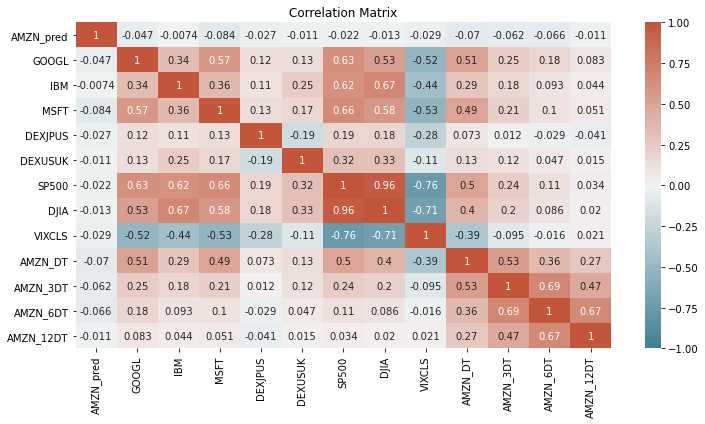

In [106]:
# Heatmap visualization

corr = dataset.corr()
plt.figure(figsize=(12,6))
plt.title('Correlation Matrix')
sns.heatmap(corr, annot=True, cbar=True, vmax=1, vmin=-1, cmap=sns.diverging_palette(220, 20, as_cmap=True)) # diverging
plt.show()

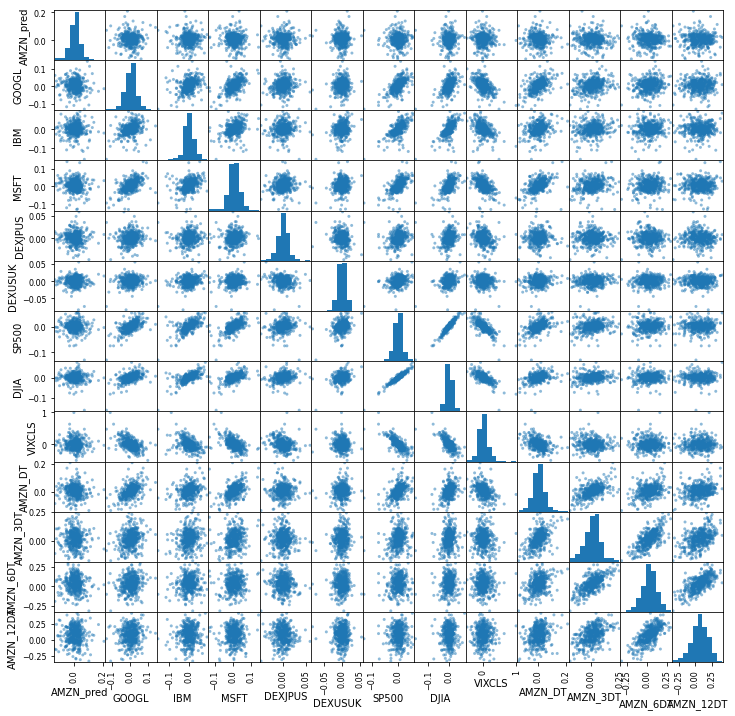

In [107]:
# Scatter plot visualization

scatter_matrix(dataset, figsize=(12,12))
plt.show()

No clear corrleation between AMZN ('AMZN_pred') and other stocks and markets. There are relatively strong negative correlation between VIXCLS and market indices and other stocks. Strong positive correlations are seen amongs lagged returns for Amazon. 

In [142]:
# Time series analysis

def tsa_seasonal_plot(r: pd.Series, period=52):
    model = sm.tsa.seasonal_decompose(r, period=period)
    fig= model.plot()
    fig.set_figheight(8)
    fig.set_figwidth(12)
    plt.show()

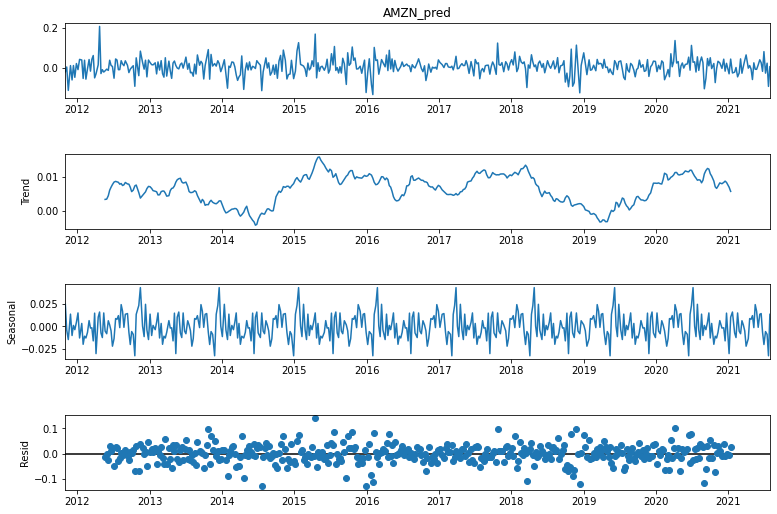

In [143]:
tsa_seasonal_plot(Y);

Amazon stocks have some trend fluctuations in returns. There has been an upward trend in the recent 2 years. The impact of Covid-19 (starting from early 2020) does not seem obvious to Amazon stock price.

# Modeling

It looks that additional data preparation is not necessary with clean and tidy dataset. Returns were log scaled so the additional preprocessing is not needed. Here, not many features are used so dimentional reduction may not be necessary.